In [1]:
import glob, os, cv2
os.environ['TF_CPP_MIN_LOG_LEVEL'] = '3'
import string
import numpy as np
from sklearn.preprocessing import MinMaxScaler
from sklearn.model_selection import train_test_split, KFold
from tensorflow.keras.models import Model, load_model
from tensorflow.keras.layers import *
from tensorflow.keras.optimizers import Adam, SGD, RMSprop
from tensorflow.keras.regularizers import L2
from tensorflow.keras.callbacks import LearningRateScheduler, ModelCheckpoint
import tensorflow.keras.backend as K
import tensorflow as tf
from tensorflow.keras import layers
import matplotlib.pyplot as plt
import time



In [2]:
(train_images, train_labels), (_,_) = tf.keras.datasets.mnist.load_data()
train_images = train_images.reshape(train_images.shape[0], 28,28,1).astype('float32')
train_images = (train_images - 127.5) / 127.5

BUFFER_SIZE = 60000
BATCH_SIZE = 256

train_dataset = tf.data.Dataset.from_tensor_slices(train_images).shuffle(BUFFER_SIZE).batch(BATCH_SIZE)


In [3]:
def make_generator_model():
    model = tf.keras.Sequential()
    model.add(layers.Dense(7*7*256, use_bias=False, input_shape=(100,)))
    model.add(layers.BatchNormalization())
    model.add(layers.LeakyReLU())
    
    model.add(layers.Reshape((7,7,256)))
    assert model.output_shape == (None, 7, 7, 256)
    
    model.add(layers.Conv2DTranspose(128,(5,5), strides=(1,1), padding='same', use_bias=False))
    assert model.output_shape == (None, 7, 7, 128)
    model.add(layers.BatchNormalization())
    model.add(layers.LeakyReLU())
    
    model.add(layers.Conv2DTranspose(64, (5,5), strides=(2,2), padding='same', use_bias=False))
    assert model.output_shape == (None, 14, 14, 64)
    model.add(layers.BatchNormalization())
    model.add(layers.LeakyReLU())
    
    model.add(layers.Conv2DTranspose(1, (5,5), strides=(2,2), padding='same', use_bias=False, activation='tanh'))
    assert model.output_shape == (None, 28, 28, 1)
    
    return model
    
    
def make_discriminator_model():
    model = tf.keras.Sequential()
    model.add(layers.Conv2D(64, (5,5), strides=(2,2), padding='same', input_shape=[28,28,1]))
    model.add(layers.LeakyReLU())
    model.add(layers.Dropout(0.3))
    
    model.add(layers.Conv2D(128, (5,5), strides=(2,2), padding='same'))
    model.add(layers.LeakyReLU())
    model.add(layers.Dropout(0.3))
    
    model.add(layers.Flatten())
    model.add(layers.Dense(1))
    
    return model

In [4]:

cross_entropy = tf.keras.losses.BinaryCrossentropy(from_logits=True)

def discriminator_loss(real_output, fake_output):
    real_loss = cross_entropy(tf.ones_like(real_output), real_output)
    fake_loss = cross_entropy(tf.zeros_like(fake_output), fake_output)
    total_loss = real_loss + fake_loss
    return total_loss

def generator_loss(fake_output):
    return cross_entropy(tf.ones_like(fake_output), fake_output)

generator_optimizer = tf.keras.optimizers.Adam(1e-4)
discriminator_optimizer = tf.keras.optimizers.Adam(1e-4)



In [5]:
EPOCHS = 50
noise_dim = 100
num_examples_to_generate = 16

seed = tf.random.normal([num_examples_to_generate, noise_dim])

# @tf.function
def train_step(images):
    noise = tf.random.normal([BATCH_SIZE, noise_dim])
    
    with tf.GradientTape() as gen_tape, tf.GradientTape() as disc_tape:
        generated_images = generator(noise, training=True)
        
        real_output = discriminator(images, training=True)
        fake_output = discriminator(generated_images, training=True)
        
        gen_loss = generator_loss(fake_output)
        disc_loss = discriminator_loss(real_output, fake_output)
        
    gradients_of_generator = gen_tape.gradient(gen_loss, generator.trainable_variables)
    gradients_of_discriminator = disc_tape.gradient(disc_loss, discriminator.trainable_variables)
    
    generator_optimizer.apply_gradients(zip(gradients_of_generator, generator.trainable_variables))
    discriminator_optimizer.apply_gradients(zip(gradients_of_discriminator, discriminator.trainable_variables))


def train(dataset, epochs):
    for epoch in range(epochs):
        start = time.time()
        
        for image_batch in dataset:
            train_step(image_batch)
            
        print(f'epoch : {epoch}, time : {time.time()-start}')
    predictions = generator(seed, training=False)
    
    for i in range(predictions.shape[0]):
        plt.subplot(4,4,i+1)
        plt.imshow(predictions[i, :, :, 0] * 127.5 + 127.5, cmap='gray')
        plt.axis('off')
        
    plt.show()

epoch : 0, time : 11.82614803314209
epoch : 1, time : 8.536651849746704
epoch : 2, time : 8.612901449203491
epoch : 3, time : 8.563490629196167
epoch : 4, time : 8.365534543991089
epoch : 5, time : 8.420036554336548
epoch : 6, time : 8.506346225738525
epoch : 7, time : 8.473788738250732
epoch : 8, time : 8.562000274658203
epoch : 9, time : 8.582148313522339
epoch : 10, time : 8.468674898147583
epoch : 11, time : 8.35971736907959
epoch : 12, time : 8.41130542755127
epoch : 13, time : 8.511818647384644
epoch : 14, time : 8.499048471450806
epoch : 15, time : 8.37679147720337
epoch : 16, time : 8.526751279830933
epoch : 17, time : 8.562686443328857
epoch : 18, time : 8.589944839477539
epoch : 19, time : 8.56121015548706
epoch : 20, time : 8.530737161636353
epoch : 21, time : 8.422004699707031
epoch : 22, time : 8.473937511444092
epoch : 23, time : 8.354246616363525
epoch : 24, time : 8.499162435531616
epoch : 25, time : 8.572491645812988
epoch : 26, time : 8.66709303855896
epoch : 27, time

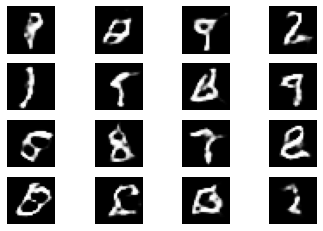

In [6]:
generator = make_generator_model()
discriminator = make_discriminator_model()

train(train_dataset, EPOCHS)

epoch : 0, time : 8.69619607925415
epoch : 1, time : 8.523022651672363
epoch : 2, time : 8.503074169158936
epoch : 3, time : 8.458801984786987
epoch : 4, time : 8.457465171813965
epoch : 5, time : 8.478855609893799
epoch : 6, time : 8.388782262802124
epoch : 7, time : 8.25570797920227
epoch : 8, time : 8.476229429244995
epoch : 9, time : 8.36798644065857
epoch : 10, time : 8.492787599563599
epoch : 11, time : 8.550710916519165
epoch : 12, time : 8.410035133361816
epoch : 13, time : 8.428669214248657
epoch : 14, time : 8.467512845993042
epoch : 15, time : 8.55301570892334
epoch : 16, time : 8.542487621307373
epoch : 17, time : 8.627280950546265
epoch : 18, time : 8.355050802230835
epoch : 19, time : 8.481209993362427
epoch : 20, time : 8.539873838424683
epoch : 21, time : 8.51699686050415
epoch : 22, time : 8.50617265701294
epoch : 23, time : 8.502516269683838
epoch : 24, time : 8.405969142913818
epoch : 25, time : 8.609556198120117
epoch : 26, time : 8.564534902572632
epoch : 27, time 

epoch : 220, time : 8.429505109786987
epoch : 221, time : 8.614844799041748
epoch : 222, time : 8.3308687210083
epoch : 223, time : 8.558078527450562
epoch : 224, time : 8.508061408996582
epoch : 225, time : 8.381574392318726
epoch : 226, time : 8.53552794456482
epoch : 227, time : 8.47761082649231
epoch : 228, time : 8.547643184661865
epoch : 229, time : 8.599773645401001
epoch : 230, time : 8.647797346115112
epoch : 231, time : 8.511354446411133
epoch : 232, time : 8.434324264526367
epoch : 233, time : 8.633135795593262
epoch : 234, time : 8.572591304779053
epoch : 235, time : 8.669729948043823
epoch : 236, time : 8.466041326522827
epoch : 237, time : 8.560382604598999
epoch : 238, time : 8.426812410354614
epoch : 239, time : 8.562377452850342
epoch : 240, time : 8.605998277664185
epoch : 241, time : 8.63543438911438
epoch : 242, time : 8.524314403533936
epoch : 243, time : 8.435112237930298
epoch : 244, time : 8.661175727844238
epoch : 245, time : 8.477183818817139
epoch : 246, time

epoch : 437, time : 8.482271432876587
epoch : 438, time : 8.400558233261108
epoch : 439, time : 8.485438346862793
epoch : 440, time : 8.392260789871216
epoch : 441, time : 8.581348180770874
epoch : 442, time : 8.410464525222778
epoch : 443, time : 8.66175103187561
epoch : 444, time : 8.548174858093262
epoch : 445, time : 8.61694884300232
epoch : 446, time : 8.391666412353516
epoch : 447, time : 8.700297117233276
epoch : 448, time : 8.471872568130493
epoch : 449, time : 8.544466495513916
epoch : 450, time : 8.536332607269287
epoch : 451, time : 8.435444116592407
epoch : 452, time : 8.568982601165771
epoch : 453, time : 8.366078853607178
epoch : 454, time : 8.42138671875
epoch : 455, time : 8.502660512924194
epoch : 456, time : 8.53818154335022
epoch : 457, time : 8.453706979751587
epoch : 458, time : 8.65764570236206
epoch : 459, time : 8.531188488006592
epoch : 460, time : 8.67170262336731
epoch : 461, time : 8.44421648979187
epoch : 462, time : 8.608628273010254
epoch : 463, time : 8.

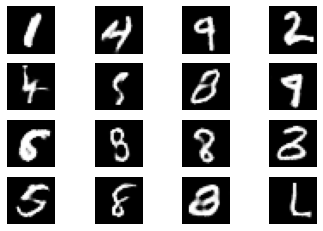

In [7]:
train(train_dataset, 500)